In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41269")
client

<Client: 'tcp://127.0.0.1:41269' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:36443' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
spec = '/tank/spectre/tuchida/NA-wavelets/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0
sreg = ['A','B','C','D','E','F']

dCs = 1e-5
Cs = xr.open_dataset(op.join(savedir,"Max-sound-speed_1967-01-01.nc")).Cs

ntheta = 36
xo = 50e3
ss = xr.open_zarr(
    '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' 
                  % reg).scale / xo
# s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
#                  coords={'scale':np.arange(.5,10.5,.5)}
#                 )

# Wavelet
## Uniform grid

In [15]:
diags = np.concatenate((np.arange(-10,-1),np.arange(2,11)))
# diags = np.arange(-1,2)
nmembs = np.arange(100,148)
xchunk = 100
ychunk = 100

ng = 2

iiter = 1419120
# iiter = 1421280
# iiter = 1423440

for dg in diags[:]:
    nx = 0
    ny = dg
    
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(ys[reg]-5-ng/12+ny/12,ys[reg]+5+ng/12+ny/12),
                               YG=slice(ys[reg]-5-ng/12+ny/12,ys[reg]+5+ng/12+ny/12),
                               XC=slice(xs[reg]-5-ng/12+nx/12,xs[reg]+5+ng/12+nx/12),
                               XG=slice(xs[reg]-5-ng/12+nx/12,xs[reg]+5+ng/12+nx/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    if len(dsb.XG) > len(dsb.XC):
        dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
        dsb = dsb.isel(XC=slice(None,-1))
    
    grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #         'Y': {'center': 'YC', 'left': 'YG'},
            #         'X': {'center': 'XC', 'left': 'XG'}}
           )
    
    dsq = xr.open_zarr(op.join(savedir,'SnapErtelPV/%2dmembers/%010d.zarr'
                               % (len(nmembs),iiter))
                      ).sel(YC=slice(ys[reg]-5-ng/12+ny/12,ys[reg]+5+ng/12+ny/12),
                            XC=slice(xs[reg]-5-ng/12+nx/12,xs[reg]+5+ng/12+nx/12)
                           ).chunk({'Z':1,'YC':-1,'XC':-1})
    
    if len(dsq.XC) > len(dsb.XC):
        dsq = dsq.isel(XC=slice(None,-1))
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5-ng/12+ny/12,
                                                            ys[reg]+5+ng/12+ny/12),
                                                   YG=slice(ys[reg]-5-ng/12+ny/12,
                                                            ys[reg]+5+ng/12+ny/12),
                                                   XC=slice(xs[reg]-5-ng/12+nx/12,
                                                            xs[reg]+5+ng/12+nx/12),
                                                   XG=slice(xs[reg]-5-ng/12+nx/12,
                                                            xs[reg]+5+ng/12+nx/12)
                                                  )
        else:
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5-ng/12+ny/12,
                                                            ys[reg]+5+ng/12+ny/12),
                                                   YG=slice(ys[reg]-5-ng/12+ny/12,
                                                            ys[reg]+5+ng/12+ny/12),
                                                   XC=slice(xs[reg]-5-ng/12+nx/12,
                                                            xs[reg]+5+ng/12+nx/12),
                                                   XG=slice(xs[reg]-5-ng/12+nx/12,
                                                            xs[reg]+5+ng/12+nx/12)
                                                  )
            ds = xr.concat([ds, ds1], dim='nmemb')
            ds1.close()
            
        # print(nmemb)

                # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(None,-1))  
        
    xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                    ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng))
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                    ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng))
    Ny, Nx = xT.shape
    xT = xT - xT.isel(XC=Nx//2)
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    dx = ds.dxC.isel(YC=slice(ng,-ng),XG=slice(ng,-ng)).min().values
    dy = ds.dyC.isel(YG=slice(ng,-ng),XC=slice(ng,-ng)).min().values
    N = ds.THETA.isel(nmemb=0,Z=0,YC=slice(ng,-ng),XC=slice(ng,-ng)).shape
    
    v = ds.VVEL
    u = ds.UVEL
    w = ds.WVEL
    PVb = (dsq.bEPVh + dsq.bEPVv)
    PVp = (dsq.pEPVh + dsq.pEPVv)
    PV = PVb + PVp
    
    xA = (ds.dyG * ds.drF).reset_coords(drop=True)
    yA = (ds.dxG * ds.drF).reset_coords(drop=True)
    
    utTrans = u.reset_coords(drop=True) * xA * ds.hFacW
    vtTrans = v.reset_coords(drop=True) * yA * ds.hFacS
    rtTrans = (w*ds.rA).reset_coords(drop=True)
    Auq = (utTrans
           * grid.interp(PVp,'X',boundary='extend')
          )
    Avq = (vtTrans
           * grid.interp(PVp,'Y',boundary='extend')
          )
    Awq = (rtTrans
           * grid.interp(PVp,'Z',boundary='extend')
          )

    Aq = ((grid.diff(Auq,'X',boundary='extend')
           + grid.diff(Avq,'Y',boundary='extend')
           - grid.diff(Awq,'Z',boundary='extend')
          ) / ds.drF/ds.rA/ds.hFacC
         ).where(ds.maskC!=0.).isel(Z=[18],YC=slice(ng,-ng),XC=slice(ng,-ng)
                                   ).compute()
    
    UtTrans = u.reset_coords(drop=True) * xA * ds.hFacW
    VtTrans = v.reset_coords(drop=True) * yA * ds.hFacS
    RtTrans = (w*ds.rA).reset_coords(drop=True)
    AUQ = (UtTrans
           * grid.interp(PV,'X',boundary='extend')
          )
    AVQ = (VtTrans
           * grid.interp(PV,'Y',boundary='extend')
          )
    AWQ = (RtTrans
           * grid.interp(PV,'Z',boundary='extend')
          )

    AQ = ((grid.diff(AUQ,'X',boundary='extend')
           + grid.diff(AVQ,'Y',boundary='extend')
           - grid.diff(AWQ,'Z',boundary='extend')
          ) / ds.drF/ds.rA/ds.hFacC
         ).where(ds.maskC!=0.).isel(Z=[18],YC=slice(ng,-ng),XC=slice(ng,-ng)
                                   ).compute()
    
    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    rAterp = griddata((xT, yT), 
                      ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).values.flatten(),
                      (xxx, yyy) 
                     ).T
    
    PVterp = xr.DataArray(np.ones_like(Aq), dims=Aq.dims,
                          coords={'nmemb':nmembs,'Z':Aq.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
    PVterb = xr.DataArray(np.ones_like(AQ), dims=AQ.dims,
                          coords={'nmemb':nmembs,'Z':AQ.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
    Aqterp = xr.DataArray(np.ones_like(Aq), dims=Aq.dims,
                          coords={'nmemb':nmembs,'Z':Aq.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
    AQterp = xr.DataArray(np.ones_like(AQ), dims=AQ.dims,
                          coords={'nmemb':nmembs,'Z':AQ.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )

    for nn in range(len(nmembs)):           
        PVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                          (PVp.isel(Z=[18],YC=slice(ng,-ng),
                                                    XC=slice(ng,-ng))
                                           * ds.rA.isel(YC=slice(ng,-ng),
                                                        XC=slice(ng,-ng))
                                          ).isel(nmemb=nn).values.flatten(),
                                          (xxx, yyy) 
                                         ).T 
        PVterb[dict(nmemb=nn)] = griddata((xT, yT), 
                                          (PV.isel(Z=[18],YC=slice(ng,-ng),
                                                   XC=slice(ng,-ng))
                                           * ds.rA.isel(YC=slice(ng,-ng),
                                                        XC=slice(ng,-ng))
                                          ).isel(nmemb=nn).values.flatten(),
                                          (xxx, yyy) 
                                         ).T  
        AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                          (AQ*ds.rA.isel(YC=slice(ng,-ng),
                                                         XC=slice(ng,-ng)
                                                        )
                                          ).isel(nmemb=nn).values.flatten(),
                                          (xxx, yyy) 
                                         ).T 
        Aqterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                          (Aq*ds.rA.isel(YC=slice(ng,-ng),
                                                         XC=slice(ng,-ng)
                                                        )
                                          ).isel(nmemb=nn).values.flatten(),
                                          (xxx, yyy) 
                                         ).T  

    PVterp = PVterp / rAterp
    Aqterp = Aqterp / rAterp
    AQterp = AQterp / rAterp
    PVterb = PVterb / rAterp

    ntheta = 36
    iso_csQAQ = xwavelet.wvlt_cross_spectrum(
                        PVterb, AQterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
                )
    iso_csQAq = xwavelet.wvlt_cross_spectrum(
                        PVterp, Aqterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
                )
            
    isoAq = -iso_csQAq
    isoAQ = -iso_csQAQ

    dsave = isoAq.to_dataset(name='Aq')
    dsave['AQ'] = isoAQ
    dsave.encoding = {}
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-Tot-PV_-%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-Tot-PV_-%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-Tot-PV_%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-Tot-PV_%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    # client.restart()
    print(dg)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-1000.zarr
-10


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0900.zarr
-9


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0800.zarr
-8


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0700.zarr
-7


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0600.zarr
-6


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0500.zarr
-5


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0400.zarr
-4


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0300.zarr
-3


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_-0200.zarr
-2


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0200.zarr
2


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0300.zarr
3


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0400.zarr
4


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0500.zarr
5


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0600.zarr
6


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0700.zarr
7


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0800.zarr
8


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_0900.zarr
9


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-Tot-PV_1000.zarr
10


## Spectral flux

In [7]:
reg = 0
iiter = 1419120

ds = xr.open_zarr(op.join(spec,
                          'Z0452/Points/%s/%010d/isoDiags_Tot-PV.zarr' 
                          % (sreg[reg],iiter))
                 ).isel(Z=1)
ds

<xarray.Dataset>
Dimensions:  (nmemb: 48, angle: 18, scale: 47)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04
Data variables:
    AQ       (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>
    Aq       (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>

In [8]:
ns = 1
    
for ny in range(-ns,ns+1):
    for nx in range(-ns,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-Tot-PV_-%02d-%02d.zarr' 
                                                           % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    # except:
                    #     pass
                else:
                    # try:
                    ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-Tot-PV_-%02d%02d.zarr' 
                                                           % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    # except:
                    #     pass
            else:
                if nx < 0:
                    # try:
                    ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-Tot-PV_%02d-%02d.zarr' 
                                                           % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                       'Z0452/Points/%s/%010d/isoDiags-Tot-PV_%02d%02d.zarr' 
                                                           % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass

ds

<xarray.Dataset>
Dimensions:  (nmemb: 432, angle: 18, scale: 47)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04
Data variables:
    AQ       (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>
    Aq       (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>

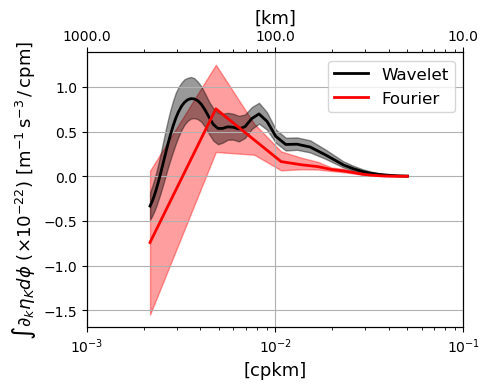

In [9]:
for reg in range(len(xs)-5):
    
    # ds = xr.open_dataset(op.join(savedir,
    #                              'AdvSnapPVTrans_region%02d_1967-01-01.zarr' 
    #                      % reg))  
    dks = xr.DataArray(np.abs(np.diff(ds.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds.scale[1:].data + ds.scale[:-1].data)}
                      ).interp(scale=ds.scale, kwargs={"fill_value": "extrapolate"})
    # eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
    #        * dks).cumsum('scale').compute()
    iso_w = (((ds.Aq) 
             ).sum('angle').compute() 
             * np.diff(ds.angle)[0]*2)
    datas = (iso_w, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Ewres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)

    # dsf = xr.open_dataset(op.join(savedir,
    #                               'FourierAdvSnapPVTrans_region%02d_1967-01-01.zarr' 
    #                               % reg))
    dsf = xr.open_zarr(op.join(spec,
                               'Z0452/Points/%s/%010d/csFourierDiags_Tot-PV.zarr' 
                               % (sreg[reg],iiter))
                      )
    # iso_cs = xrft.isotropize((dsf.App + dsf.Au + dsf.Aw + dsf.MtE).mean(['nmemb']).real, 
    #                          ["freq_YC","freq_XC"], truncate=True).compute()
    iso_cs = xrft.isotropize((dsf.qAq).real, 
                             ["freq_YC","freq_XC"], truncate=True
                            ).isel(Z=1) * 2*np.pi
    datas = (iso_cs, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Efres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)

    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
#             ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between(iso_cs.freq_r*1e3, Efres.confidence_interval.low*1e22, 
                    Efres.confidence_interval.high*1e22, 
                    alpha=.38, color='r')
    ax.fill_between((iso_w.scale)**-1*1e3, Ewres.confidence_interval.low*1e22, 
                    Ewres.confidence_interval.high*1e22, 
                    alpha=.4, color='k')
    
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e26,
    #                 'r', lw=2, label=r"Zonal")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=len(eta.angle)//2,Z=0).mean(['nmemb'])*1e26,
    #                 'c', lw=2, label=r"Meridional")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e26,
    #                 'k', lw=2, label=r"Isotropic")
    ax.plot((iso_w.scale)**-1*1e3, iso_w.mean(['nmemb'])*1e22,
            'k', lw=2, label=r"Wavelet")
    ax.plot((iso_cs.freq_r)*1e3, iso_cs.mean(['nmemb'])*1e22,
            'r', lw=2, label=r"Fourier")
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # ax.set_ylim([-5e-3,None])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(
        r"$\int\partial_k\eta_K d\phi$ ($\times 10^{-22}$) [m$^{-1}\,$s$^{-3}\,/\,$cpm]", 
                  fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(spec,
                        'Figs/WvsF-EddyEns-spectrans_3x3_Region%02d_Z452.pdf' 
                        % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF-Ens-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()

In [18]:
iiter = 1419120

for reg in range(len(xs)-5):
    
    # ds = xr.open_dataset(op.join(savedir,'AdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg))
    # ds = xr.open_zarr(op.join(spec,
    #                           'Z0452/Points/%s/%010d/isoDiags_Tot-PV.zarr' 
    #                           % (sreg[reg],iiter))
    #                  )
    dks = xr.DataArray(np.abs(np.diff(ds.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds.scale[1:].data + ds.scale[:-1].data)}
                      ).interp(scale=ds.scale, kwargs={"fill_value": "extrapolate"})
    # eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
    #        * dks).cumsum('scale').compute()
    iso_w = (((ds.AQ) 
             ).sum('angle').compute() 
             * np.diff(ds.angle)[0]*2)
    datas = (iso_w, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Ewres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)

    # dsf = xr.open_dataset(op.join(savedir,
    #                               'FourierAdvSnapPVTrans_region%02d_1967-01-01.zarr' 
    #                               % reg))
    dsf = xr.open_zarr(op.join(spec,
                               'Z0452/Points/%s/%010d/csFourierDiags_Tot-PV.zarr' 
                               % (sreg[reg],iiter))
                      )
    # iso_cs = xrft.isotropize((dsf.App + dsf.Au + dsf.Aw + dsf.MtE).mean(['nmemb']).real, 
    #                          ["freq_YC","freq_XC"], truncate=True).compute()
    iso_cs = xrft.isotropize((dsf.QAQ).real, 
                             ["freq_YC","freq_XC"], truncate=True
                            ).isel(Z=1) * 2*np.pi
    datas = (iso_cs, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Efres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)

    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
#             ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((iso_w.scale)**-1*1e3, Ewres.confidence_interval.low*1e22, 
                    Ewres.confidence_interval.high*1e22, 
                    alpha=.4, color='k')
    ax.fill_between(iso_cs.freq_r*1e3, Efres.confidence_interval.low*1e22, 
                    Efres.confidence_interval.high*1e22, 
                    alpha=.38, color='r')
    
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e26,
    #                 'r', lw=2, label=r"Zonal")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=len(eta.angle)//2,Z=0).mean(['nmemb'])*1e26,
    #                 'c', lw=2, label=r"Meridional")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e26,
    #                 'k', lw=2, label=r"Isotropic")
    ax.plot((iso_w.scale)**-1*1e3, iso_w.mean(['nmemb'])*1e22,
            'k', lw=2, label=r"Wavelet")
    ax.plot((iso_cs.freq_r)*1e3, iso_cs.mean(['nmemb'])*1e22,
            'r', lw=2, label=r"Fourier")
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # ax.set_ylim([-5e-3,None])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(
        r"$\int\partial_k\eta_K d\phi$ ($\times 10^{-22}$) [m$^{-1}$ s$^{-3}$ / cpm]", 
                  fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(savedir,'Figs/WvsF-TotEns-spectrans_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF-Ens-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


KeyboardInterrupt: 

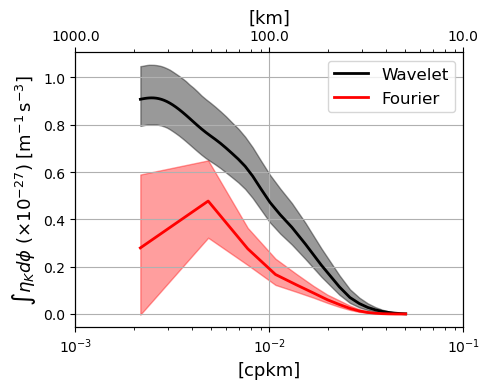

In [10]:
for reg in range(len(xs)-5):
    
    # ds = xr.open_dataset(op.join(savedir,'AdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg))
    # ds = xr.open_zarr(op.join(spec,
    #                           'Z0452/Points/%s/%010d/isoDiags_Tot-PV.zarr' 
    #                           % (sreg[reg],iiter))
    #                  )
    dks = xr.DataArray(np.abs(np.diff(ds.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds.scale[1:].data + ds.scale[:-1].data)}
                      ).interp(scale=ds.scale, kwargs={"fill_value": "extrapolate"})
    # eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
    #        * dks).cumsum('scale').compute()
    eta = (((ds.Aq) 
            * dks)[...,::-1].cumsum('scale')[...,::-1].sum('angle').compute() 
           * np.diff(ds.angle)[0]*2)
    datas = (eta, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Ewres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)

    # dsf = xr.open_dataset(op.join(savedir,
    #                               'FourierAdvSnapPVTrans_region%02d_1967-01-01.zarr' 
    #                               % reg))
    dsf = xr.open_zarr(op.join(spec,
                               'Z0452/Points/%s/%010d/csFourierDiags_Tot-PV.zarr' 
                               % (sreg[reg],iiter))
                      )
    # iso_cs = xrft.isotropize((dsf.App + dsf.Au + dsf.Aw + dsf.MtE).mean(['nmemb']).real, 
    #                          ["freq_YC","freq_XC"], truncate=True).compute()
    iso_cs = xrft.isotropize((dsf.qAq).real, 
                             ["freq_YC","freq_XC"], truncate=True
                            )
    etaf = (iso_cs * np.abs(np.diff(iso_cs.freq_r)[0])
           ).isel(Z=1)[...,::-1].cumsum('freq_r')[...,::-1].compute() * 2*np.pi
    datas = (etaf, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Efres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)

    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
#             ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between(etaf.freq_r*1e3, Efres.confidence_interval.low*1e27, 
                    Efres.confidence_interval.high*1e27, 
                    alpha=.38, color='r')
    ax.fill_between((eta.scale)**-1*1e3, Ewres.confidence_interval.low*1e27, 
                    Ewres.confidence_interval.high*1e27, 
                    alpha=.4, color='k')
    
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e26,
    #                 'r', lw=2, label=r"Zonal")
    # ax.plot((eta.scale)**-1*1e3, 
    #         eta.isel(angle=len(eta.angle)//2,Z=0).mean(['nmemb'])*1e26,
    #                 'c', lw=2, label=r"Meridional")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e26,
    #                 'k', lw=2, label=r"Isotropic")
    ax.plot((eta.scale)**-1*1e3, eta.mean(['nmemb'])*1e27,
            'k', lw=2, label=r"Wavelet")
    ax.plot((etaf.freq_r)*1e3, etaf.mean(['nmemb'])*1e27,
            'r', lw=2, label=r"Fourier")
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # ax.set_ylim([-5e-3,None])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"$\int\eta_K d\phi$ ($\times 10^{-27}$) [m$^{-1}\,$s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(spec,
                        'Figs/WvsF-EddyEns-specflux_3x3_Region%02d_Z452.pdf' 
                        % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF-Ens-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()

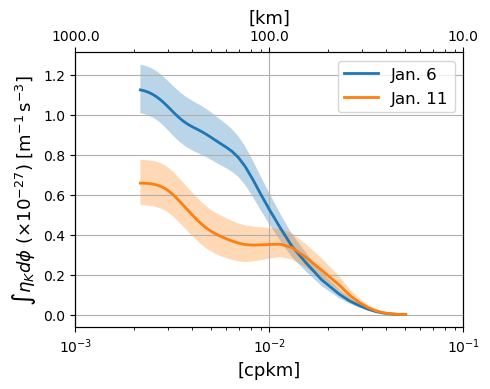

In [11]:
date = ['Jan. 6', 'Jan. 11']
clrs = ['b', 'r']

for reg in range(len(xs)-5):
    
    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    dd = 0
    for iiter in ntimes[0,1:3]:
    
        ds = xr.open_zarr(op.join(spec,
                                  'Z0452/Points/%s/%010d/isoDiags_Tot-PV.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=1)
        
        ns = 1
    
        for ny in range(-ns,ns+1):
            for nx in range(-ns,ns+1):
                if ny == 0 and nx == 0:
                    pass
                # elif ny == -1 and nx == -1:
                #     pass
                else:
                    if ny < 0:
                        if nx < 0:
                            # try:
                            ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-Tot-PV_-%02d-%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            # except:
                            #     pass
                        else:
                            # try:
                            ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                      'Z0452/Points/%s/%010d/isoDiags-Tot-PV_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            # except:
                            #     pass
                    else:
                        if nx < 0:
                            # try:
                            ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags-Tot-PV_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb') 
                            # except:
                            #     pass
                        else:
                            # try:
                            ds  = xr.concat([ds, xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags-Tot-PV_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb') 
                            # except:
                            #     pass

        
        dks = xr.DataArray(np.abs(np.diff(ds.scale**-1)).data, dims='scale',
                           coords={'scale':.5*(ds.scale[1:].data + ds.scale[:-1].data)}
                          ).interp(scale=ds.scale, kwargs={"fill_value": "extrapolate"})
        # eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
        #        * dks).cumsum('scale').compute()
        eta = (((ds.Aq) * dks
               )[...,::-1].cumsum('scale')[...,::-1].sum('angle').compute() 
               * np.diff(ds.angle)[0]*2)
        datas = (eta, )  # samples must be in a sequence
        rng = np.random.default_rng()
        Ewres = bootstrap(datas, np.mean, confidence_level=0.95,
                          # n_resamples=1000,
                          random_state=rng)
    
        ax.fill_between((eta.scale)**-1*1e3, Ewres.confidence_interval.low*1e27, 
                        Ewres.confidence_interval.high*1e27, 
                        alpha=.3)

        # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e26,
        #                 'r', lw=2, label=r"Zonal")
        # ax.plot((eta.scale)**-1*1e3, 
        #         eta.isel(angle=len(eta.angle)//2,Z=0).mean(['nmemb'])*1e26,
        #                 'c', lw=2, label=r"Meridional")
        # ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e26,
        #                 'k', lw=2, label=r"Isotropic")
        ax.plot((eta.scale)**-1*1e3, eta.mean(['nmemb'])*1e27,
                lw=2, label=date[dd])
        dd += 1
        
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # ax.set_ylim([-5e-3,None])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"$\int\eta_K d\phi$ ($\times 10^{-27}$) [m$^{-1}\,$s$^{-3}$]", 
                  fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(spec,
                        'Figs/WEns-specflux_3x3_Region%02d_Z452_temporal.pdf' 
                        % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF-Ens-specflux_reenvisioned_Region%02d_Z452.pdf'
    #                     % reg))
    plt.show()